In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, sampling, data_loading

import torch
from adabmDCA.functional import one_hot
from tqdm import tqdm
import matplotlib.pyplot as plt

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [317]:
import importlib
importlib.reload(selex_distribution)
importlib.reload(energy_models)

<module 'energy_models' from '/Users/scrotti/Aptamer2025py/energy_models.py'>

In [318]:
q = 4
L = 45

k = torch.randn(L, q)
h = torch.randn(L, q)
J = torch.randn(L, q, L, q)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
ps = selex_distribution.MultiModeDistribution(potts, normalized=False)

# def perceptron(L):
#     return torch.nn.Sequential(
#         torch.nn.Linear(L*q, 1),
#         torch.torch.nn.Softmax(dim=0)
#     )

# nns = [energy_models.GenericEnergyModel(perceptron(L)) for _ in range(2)]
# ps = selex_distribution.MultiModeDistribution(*nns, normalized=False)

Nst = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

M = 100
x_ = torch.randint(q, (M, L))
x = one_hot(x_, num_classes=q)

In [319]:
chains = torch.zeros(M, L, q)
chains[:, :, 0] = 1

t = 1
def compute_energy(x):
    return Nst.compute_energy_up_to_round(x, t)

sampling.metropolis_step_uniform_sites(chains, compute_energy)
sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=10)

In [320]:
energies = [compute_energy(chains).mean().detach().numpy()]
N = 200
for i_ in tqdm(range(N)):
    sampling.sample_metropolis_uniform_sites(chains, compute_energy, n_sweeps=1, beta=10.0)
    energies.append(compute_energy(chains).mean().detach().numpy())

  0%|          | 0/200 [00:00<?, ?it/s]

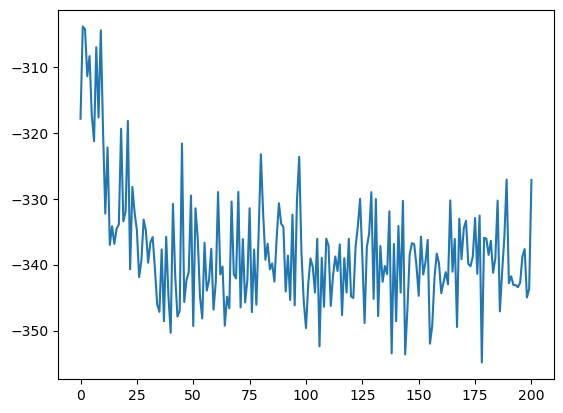

In [321]:
plt.plot(energies);

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from adabmDCA.utils import get_device, get_dtype


import sys
sys.path.append('..')
import selex_dca, utils
from utils import one_hot

In [7]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [8]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [9]:
sequences_oh = [one_hot(seq, num_classes=q).to(dtype) for seq in sequences]

In [185]:
total_reads= torch.tensor([len(seq_oh) for seq_oh in sequences_oh])

In [322]:
def init_chains(
    n_rounds: int,
    n_chains: int,
    L: int,
    q: int,
    device: torch.device,
    dtype: torch.dtype | None = None,
) -> torch.Tensor:

    if dtype is None:
        dtype = torch.float32
    chains = [torch.randint(low=0, high=q, size=(n_chains, L), device=device)
            for _ in range(n_rounds)]
    
    chains_tensor = torch.stack([one_hot(c, num_classes=q).to(dtype) for c in chains])
    
    return chains_tensor   # n_rounds, n_chains, L, q

def update_chains(chains, t, model, n_sweeps):
    compute_energy = lambda x : model.compute_energy_up_to_round(x, t-1)
    sampling.sample_metropolis_uniform_sites(torch.select(chains, 0, t), compute_energy, n_sweeps)

def compute_pearson(grad_model, grad_data):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_data)
    return torch.corrcoef(torch.stack([x, y]))[0, 1].item()

def compute_slope(grad_model, grad_data):
    x = torch.nn.utils.parameters_to_vector(grad_model)
    y = torch.nn.utils.parameters_to_vector(grad_data)
    n = len(x)
    num = n * (x @ y) - y.sum() * x.sum()
    den = n * (x @ x) - torch.square(x.sum())
    return torch.abs(num / den)

def init_history():
    history = {
        "pearson": [],
        "slope" : [],
        "pi": [],
        "grad": [],
        'grad_norm' : []
    }
    return history

In [373]:
ts = torch.arange(len(round_ids))
grad_data_cached = [] 
for t in ts:
    model.zero_grad()
    en = model.compute_energy_up_to_round(sequences_oh[t], t-1)
    en_avg = en.mean()
    en_avg.backward()
    

In [401]:
from tqdm.autonotebook import tqdm

def compute_gradient_at_round(model, chains, data_batch, t):
    # this L is not physically a likelihood, more like a computational trick
    L_model = model.compute_energy_up_to_round(chains, t).mean()
    L_data =  model.compute_energy_up_to_round(data_batch, t).mean()
    return L_model, L_data

def compute_moments_model_at_round(model, chains, t):
    # this L is not physically a likelihood, more like a computational trick
    return model.compute_energy_up_to_round(chains, t).mean()

def compute_moments_data_at_round(model, data_batch, t):
    # this L is not physically a likelihood, more like a computational trick
    return model.compute_energy_up_to_round(data_batch, t).mean()

def compute_grad_model(model, L_model, retain_graph):
    params = tuple(model.parameters())

    grad_model = torch.autograd.grad(
        outputs=L_model,
        inputs=params,
        retain_graph=retain_graph,
        create_graph=False
    )

    return grad_model

def compute_grad_data(model, L_data, retain_graph):
    params = tuple(model.parameters())

    grad_data = torch.autograd.grad(
        outputs=L_data,
        inputs=params,
        retain_graph=retain_graph,
        create_graph=False
    )

    return grad_data

def compute_gradient(model, grad_model, grad_data):
    grad_total = tuple(-(gm - ge) for gm, ge in zip(grad_model, grad_data))
    
    with torch.no_grad():
        for p, g in zip(model.parameters(), grad_total):
            p.grad = g

    return grad_total

def train(
    model: selex_distribution.MultiRoundDistribution,
    data_loaders,
    total_reads,
    chains: torch.Tensor,
    n_sweeps: int,
    lr: float,    
    max_epochs: int,
    target_pearson = 1.0,
    l2reg: float = 0.0,
    history : dict = init_history(),
    progress_bar: bool = True,
):
    n_rounds = len(data_loaders) 
    assert chains.shape[0] == n_rounds
    normalized_total_reads = total_reads / total_reads.sum(0, keepdim=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=l2reg)

    def halt_condition(epochs, pearson, slope):
        c1 = epochs > max_epochs
        c2 = pearson >= target_pearson
        c3 = abs(slope - 1.) < 0.1
        return c1 or (c2 and c3)

    epochs = 0
    pearson = -1
    slope = -1
    if progress_bar: 
        pbar = tqdm(
            initial=0,
            total=max_epochs,
            colour="red",
            dynamic_ncols=True,
            leave=False,
            ascii="-#",
            bar_format="{desc} {percentage:.2f}%[{bar}] Epoch: {n}/{total_fmt} [{elapsed}]"
        )
    while not halt_condition(epochs, pearson, slope):
        optimizer.zero_grad()
        L_model = L_data = 0
        for t in range(n_rounds):
            # update chains
            with torch.no_grad():
                update_chains(chains, t, model, n_sweeps)
            # extract batch of data from round t
            data_batch = next(iter(data_loaders[t]))
            # compute gradient
            L_m = compute_moments_model_at_round(model, chains[t].clone(), t-1)
            L_d = compute_moments_data_at_round(model, data_batch, t-1)
            L_model = L_model + normalized_total_reads[t] * L_m
            L_data = L_data + normalized_total_reads[t] * L_d
            # TODO: compute round-wise convergence metrics

        # Compute gradient
        grad_model = compute_grad_model(model, L_model, retain_graph=True)
        grad_data = compute_grad_data(model, L_data, retain_graph=False)
        grad_total = compute_gradient(model, grad_model, grad_data)
        # do gradient step on params
        optimizer.step()

        # convergence metrics
        pearson = compute_pearson(grad_model, grad_data)
        slope = compute_slope(grad_model, grad_data)
        # TODO: callbacks
        pi = model.round_zero.h.detach().exp()
        pi /= pi.sum(dim=1, keepdim=True)
        history["pi"].append(pi)
        grad_vec = torch.nn.utils.parameters_to_vector(grad_total)
        grad_norm = torch.sqrt(torch.square(grad_vec).sum()) / len(grad_vec)

        epochs += 1
        if progress_bar:
            pbar.n = epochs
            pbar.set_description(f"Epoch {epochs}, Pearson = {pearson:.3f}, Gradient norm = {grad_norm:.4e}")

        history["pearson"].append(pearson)
        history["slope"].append(slope)
        history["grad"].append(grad_vec)
        history['grad_norm'].append(grad_norm)

In [403]:
k = torch.zeros(L, q)
h = torch.zeros(L, q)
J = torch.zeros(L, q, L, q)

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor([[1],[1]])

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(indep, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [404]:
batch_size = 2**20
n_chains = 1000

datasets = [data_loading.SelexRoundDataset(seq_oh) for seq_oh in sequences_oh]
data_loaders = [torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True) for ds in datasets]
n_rounds = len(data_loaders) 
history = init_history()
chains = init_chains(n_rounds, n_chains, L, q, device)

## Check gradient calculations

In [405]:
t = 1
x = chains[t].clone()
en = model.compute_energy_up_to_round(x, t)
en_avg = en.mean()
en_avg.backward()

In [406]:
(potts.J.grad == potts.J.grad * potts.mask).all()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Tensor'

In [407]:
fi, fij, Rt = utils.frequences_from_sequences_oh(x)

In [408]:
torch.allclose(-fi*(t+1), indep.h.grad)

True

In [409]:
torch.allclose(-fi, Ns0.h.grad)

True

## TODO
A ogni classe assegnare dei metodi calcola media empirica, calcola media modello, che defaultano a usare le batch/chains ma altrimenti fanno una cosa piu efficiente
Metropolis efficiente per modelli fattorizzati

Trovare buon batch size calcolando l'energia con diversi batch e guardando deviazione

Separare calcolo gradiente empirico e modello per mettere quello giusto

In [410]:
n_sweeps = 10
lr = 0.005
max_epochs = 1000

train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, history=history)

 0.00%[                                      ] Epoch: 0/1000 [00:00]

KeyboardInterrupt: 

In [ ]:
plt.plot(history["grad"][-1])

In [ ]:
plt.plot(history["grad_norm"])

In [ ]:
plt.plot(history["pearson"])

In [ ]:
plt.plot(history["slope"])

In [252]:
fi, fij, Rt = utils.frequences_from_sequences_oh(sequences_oh[0])

In [ ]:
pi = history["pi"][-1]
x = pi.view(-1)
y = fi.view(-1)
plt.scatter(x, y)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot(x,x, color='red')

In [ ]:
pearsons = []
for pi in history["pi"]:
    x = pi.view(-1)
    y = fi.view(-1)
    pearsons.append(torch.corrcoef(torch.stack([x, y]))[0, 1].item())

plt.plot(pearsons)

NameError: name 'potts_zerosum' is not defined

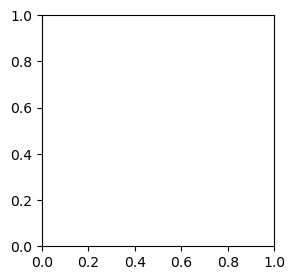

In [58]:
from IPython.display import display, Latex

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))